In [1]:
import matplotlib.pyplot as plt
import numpy as np
import ElementsEnv
from glob import glob
import itertools
import os
from tqdm.notebook import tqdm
from scipy.spatial.distance import pdist, squareform, cdist

plt.rcParams['figure.figsize'] = (15, 5)

%erun Elements 5.12.0

os.environ['ELEMENTS_AUX_PATH'] = '/home/aalvarez/Work/Projects/PHZ_NNPZ/PHZ_NNPZ/nnpz/auxdir/'

sys.path.append('/home/aalvarez/Work/Projects/PHZ_NNPZ/PHZ_NNPZ/nnpz/python/')

%load_ext autoreload
%autoreload 2

from nnpz.photometry import DirectoryFilterProvider, FnuuJyPrePostProcessor, PhotometryCalculator

In [2]:
filters_provider = DirectoryFilterProvider('/home/aalvarez/Work/Data/SC8/PHZ_Calibration_28jan21/PhosphorosRootEcdmHandler/Phosphoros/AuxiliaryData/Filters/')
filter_map = {}
filter_names = filters_provider.getFilterNames()
for filter_name in filter_names:
    filter_map[filter_name] = filters_provider.getFilterTransmission(filter_name)

In [3]:
filter_avg_trans = []
for filter_name in filter_map:
    filter_avg_trans.append(np.average(filter_map[filter_name][:,0], weights=filter_map[filter_name][:,1]))
filter_names = np.asarray(filter_names)
filter_names = filter_names[np.argsort(filter_avg_trans)]
filter_names

array(['kids/u', 'lsst/u', 'kids/g', 'lsst/g', 'des/g', 'lsst/r',
       'kids/r', 'des/r', 'euclid/VIS', 'lsst/i', 'kids/i', 'des/i',
       'lsst/z', 'des/z', 'lsst/y', 'euclid/Y', 'euclid/J', 'euclid/H'],
      dtype='<U10')

In [4]:
prepost = FnuuJyPrePostProcessor(filter_map)
calculator = PhotometryCalculator(filter_map, prepost)

In [5]:
sed_names = np.asarray([
    # O
    'uko5v', 'uko8iii', 'uko9v',
    # B
    'ukb0i', 'ukb0v', 'ukb12iii', 'ukb1i', 'ukb1v', 'ukb2ii', 'ukb2iv', 'ukb3i', 'ukb3iii',
    'ukb3v', 'ukb57v', 'ukb5i', 'ukb5ii', 'ukb5iii', 'ukb6iv', 'ukb8i', 'ukb8v', 'ukb9iii', 'ukb9v',
    # A
    'uka0i', 'uka0iii', 'uka0iv', 'uka0v', 'uka2i', 'uka2v',
    'uka3iii', 'uka3v', 'uka47iv', 'uka5iii', 'uka5v', 'uka7iii', 'uka7v',
    # F normal
    'ukf02iv', 'ukf0i', 'ukf0ii', 'ukf0iii', 'ukf0v', 'ukf2ii', 'ukf2iii',
    'ukf2v', 'ukf5i', 'ukf5iii', 'ukf5iv', 'ukf5v', 'ukf6v', 'ukf8i', 'ukf8iv', 'ukf8v',
    # F metal rich
    'ukrf6v', 'ukrf8v',
    # F metal weak,
    'ukwf5v', 'ukwf8v',
    # G normal
    'ukg0i',  'ukg0iii', 'ukg0iv', 'ukg0v', 'ukg2i', 'ukg2iv',
    'ukg2v', 'ukg5i', 'ukg5ii', 'ukg5iii', 'ukg5iv', 'ukg5v', 'ukg8i', 
    'ukg8iii',  'ukg8iv',  'ukg8v', 
    # G metal rich
    'ukrg0v', 'ukrg5iii', 'ukrg5v',
    # G metal weak
    'ukwg0v', 'ukwg5iii', 'ukwg5v', 'ukwg8iii',
    # K normal
    'ukk01ii', 'ukk0iii', 'ukk0iv', 'ukk0v', 'ukk1iii', 'ukk1iv', 
    'ukk2i', 'ukk2iii', 'ukk2v', 'ukk34ii', 'ukk3i', 'ukk3iii', 
    'ukk3iv', 'ukk3v', 'ukk4i', 'ukk4iii', 'ukk4v', 'ukk5iii', 'ukk5v', 'ukk7v', 
    # K metal rich
    'ukrk0iii', 'ukrk0v', 'ukrk1iii', 'ukrk2iii', 'ukrk3iii', 'ukrk4iii', 'ukrk5iii',
    # K metal weak
    'ukwk0iii', 'ukwk1iii', 'ukwk2iii', 'ukwk3iii', 'ukwk4iii',
    # M
    'ukm0iii', 'ukm0v', 'ukm10iii', 'ukm1iii', 'ukm1v', 'ukm2.5v', 'ukm2i', 'ukm2iii', 'ukm2v', 'ukm3ii', 'ukm3iii', 
    'ukm3v', 'ukm4iii', 'ukm4v', 'ukm5iii', 'ukm5v', 'ukm6iii', 'ukm6v', 'ukm7iii', 'ukm8iii', 'ukm9iii', 
])
len(sed_names)

131

In [6]:
seds = np.zeros((4771, len(sed_names) + 1), dtype=np.float32)
for i, sf in enumerate(tqdm(sed_names)):
    s = np.loadtxt('/home/aalvarez//Phosphoros/AuxiliaryData/SEDs/Pickles/' + sf + '.dat')
    if i == 0:
        seds[:, 0] = s[:, 0]
    seds[:, i+1] = s[:, 1]

  0%|          | 0/131 [00:00<?, ?it/s]

In [7]:
seds[:, 1:].shape

(4771, 131)

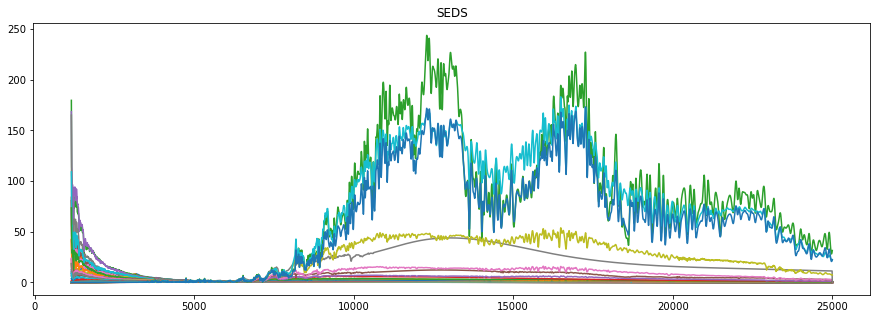

In [8]:
plt.figure()
plt.title('SEDS')
plt.plot(seds[:,0], seds[:, 1:])
plt.show()

# Photometry

In [9]:
dtype = calculator.compute(seds[:,0:2]).dtype
photo = np.zeros(seds.shape[1] - 1, dtype=dtype)
for i in tqdm(range(seds.shape[1]-1)):
    photo[i] = calculator.compute(seds[:, [0, i+1]])[0]

  0%|          | 0/131 [00:00<?, ?it/s]

In [10]:
bands = ['lsst/u', 'lsst/g', 'lsst/r', 'lsst/i', 'lsst/z', 'euclid/VIS', 'euclid/H']
color_names = []
for i in range(len(bands)):
    for j in range(i+1, len(bands)):
        color_names.append((bands[i], bands[j]))
pw = []
for i in range(len(color_names)):
    for j in range(i+1, len(color_names)):
        pw.append((i, j))
print(color_names, len(pw))

[('lsst/u', 'lsst/g'), ('lsst/u', 'lsst/r'), ('lsst/u', 'lsst/i'), ('lsst/u', 'lsst/z'), ('lsst/u', 'euclid/VIS'), ('lsst/u', 'euclid/H'), ('lsst/g', 'lsst/r'), ('lsst/g', 'lsst/i'), ('lsst/g', 'lsst/z'), ('lsst/g', 'euclid/VIS'), ('lsst/g', 'euclid/H'), ('lsst/r', 'lsst/i'), ('lsst/r', 'lsst/z'), ('lsst/r', 'euclid/VIS'), ('lsst/r', 'euclid/H'), ('lsst/i', 'lsst/z'), ('lsst/i', 'euclid/VIS'), ('lsst/i', 'euclid/H'), ('lsst/z', 'euclid/VIS'), ('lsst/z', 'euclid/H'), ('euclid/VIS', 'euclid/H')] 210


In [11]:
np.random.shuffle(pw)

In [12]:
colors = np.zeros((len(photo), len(color_names)))
for i, (a, b) in enumerate(color_names):
    colors[:, i] = photo[a] / photo[b]

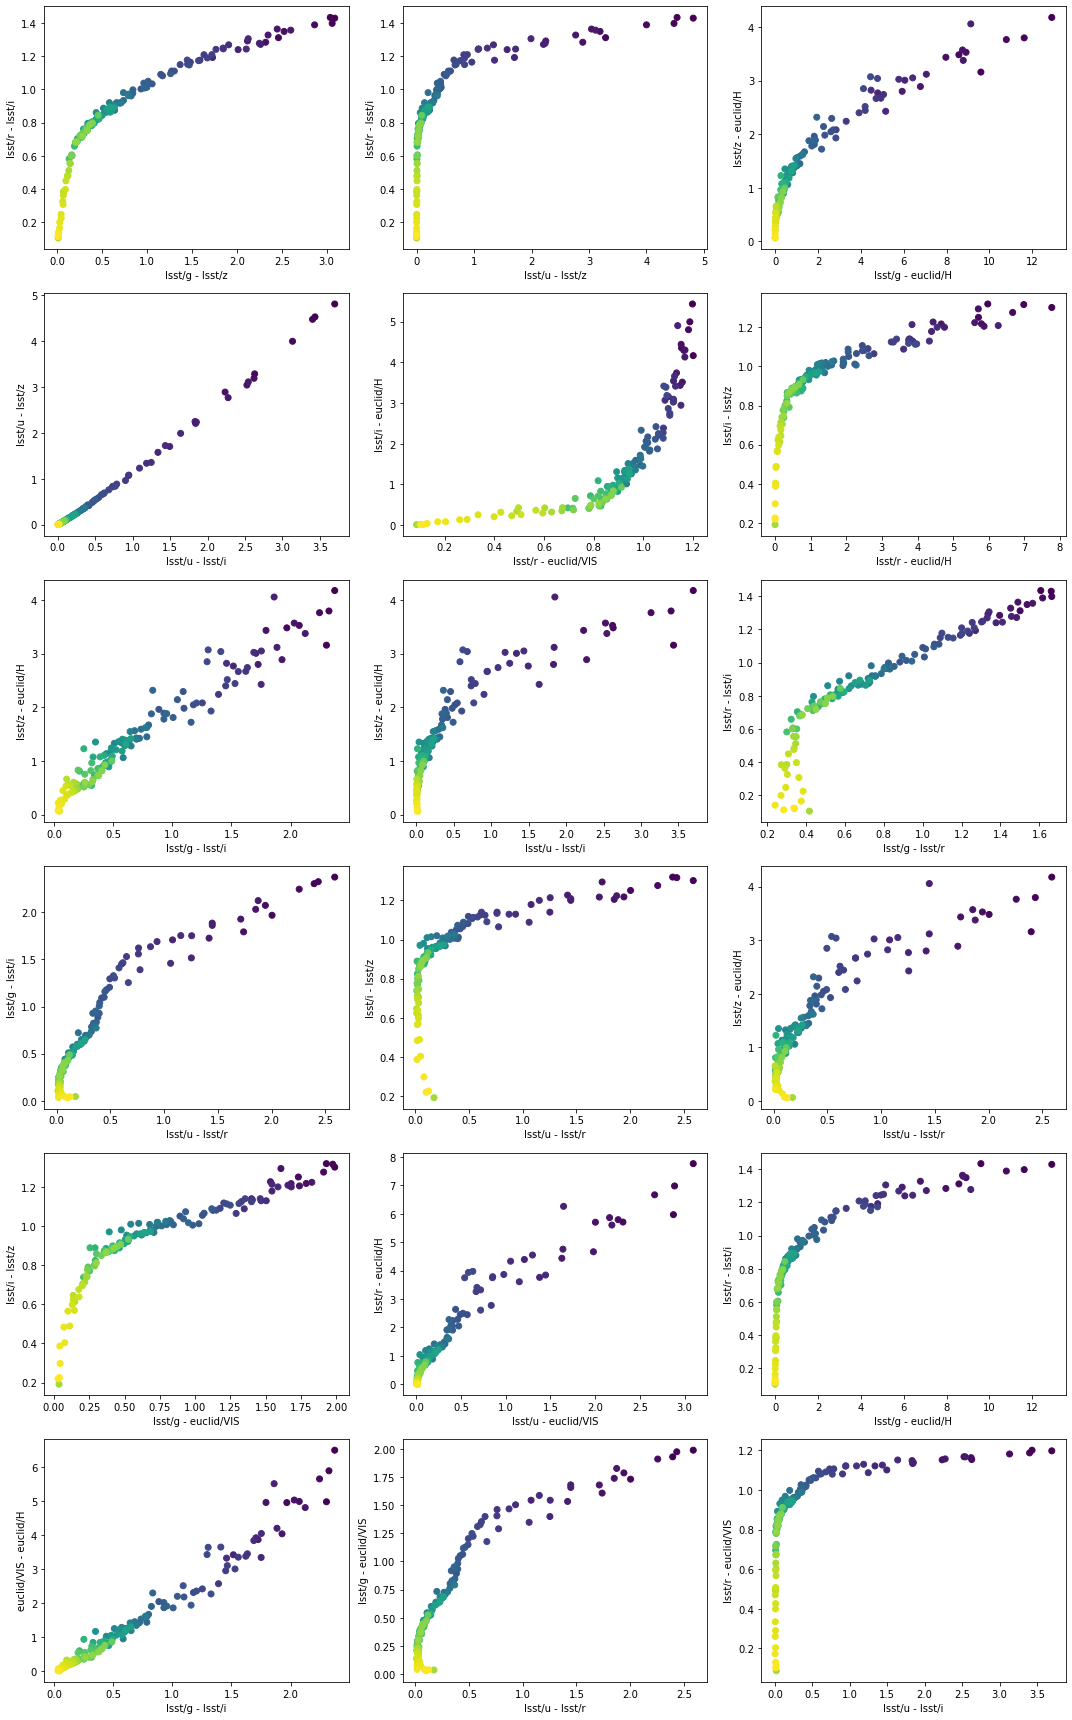

In [13]:
nrows = 6
fig, axes = plt.subplots(ncols=3, nrows=nrows, figsize=(15, 4 * nrows))

for ax, (a, b) in zip(axes.ravel(), pw):
    ax.scatter(colors[:, a], colors[:, b], c=np.arange(seds.shape[1]-1))
    ax.set_xlabel(' - '.join(color_names[a]))
    ax.set_ylabel(' - '.join(color_names[b]))
plt.tight_layout()
plt.show()

In [14]:
pdistances = squareform(pdist(colors, 'chebyshev'))

In [15]:
distances = []
for i in range(len(sed_names)-1):
    distances.append(pdistances[i, i+1])
distances = np.asarray(distances)
ends = np.cumsum(distances)
starts = np.concatenate([[0], ends[:-1]])

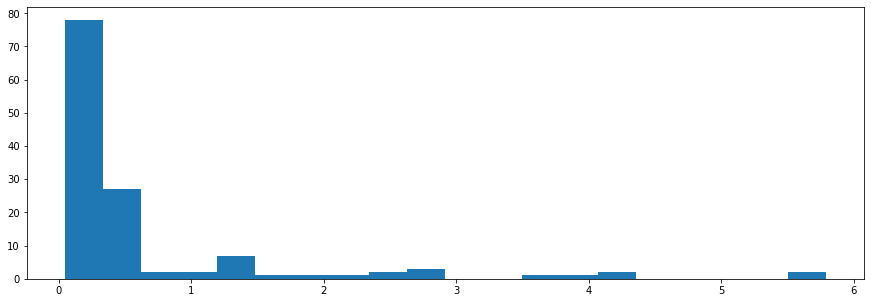

0.2695406973361969

In [16]:
plt.figure()
plt.hist(distances, bins=20)
plt.show()
medd = np.median(distances)
medd

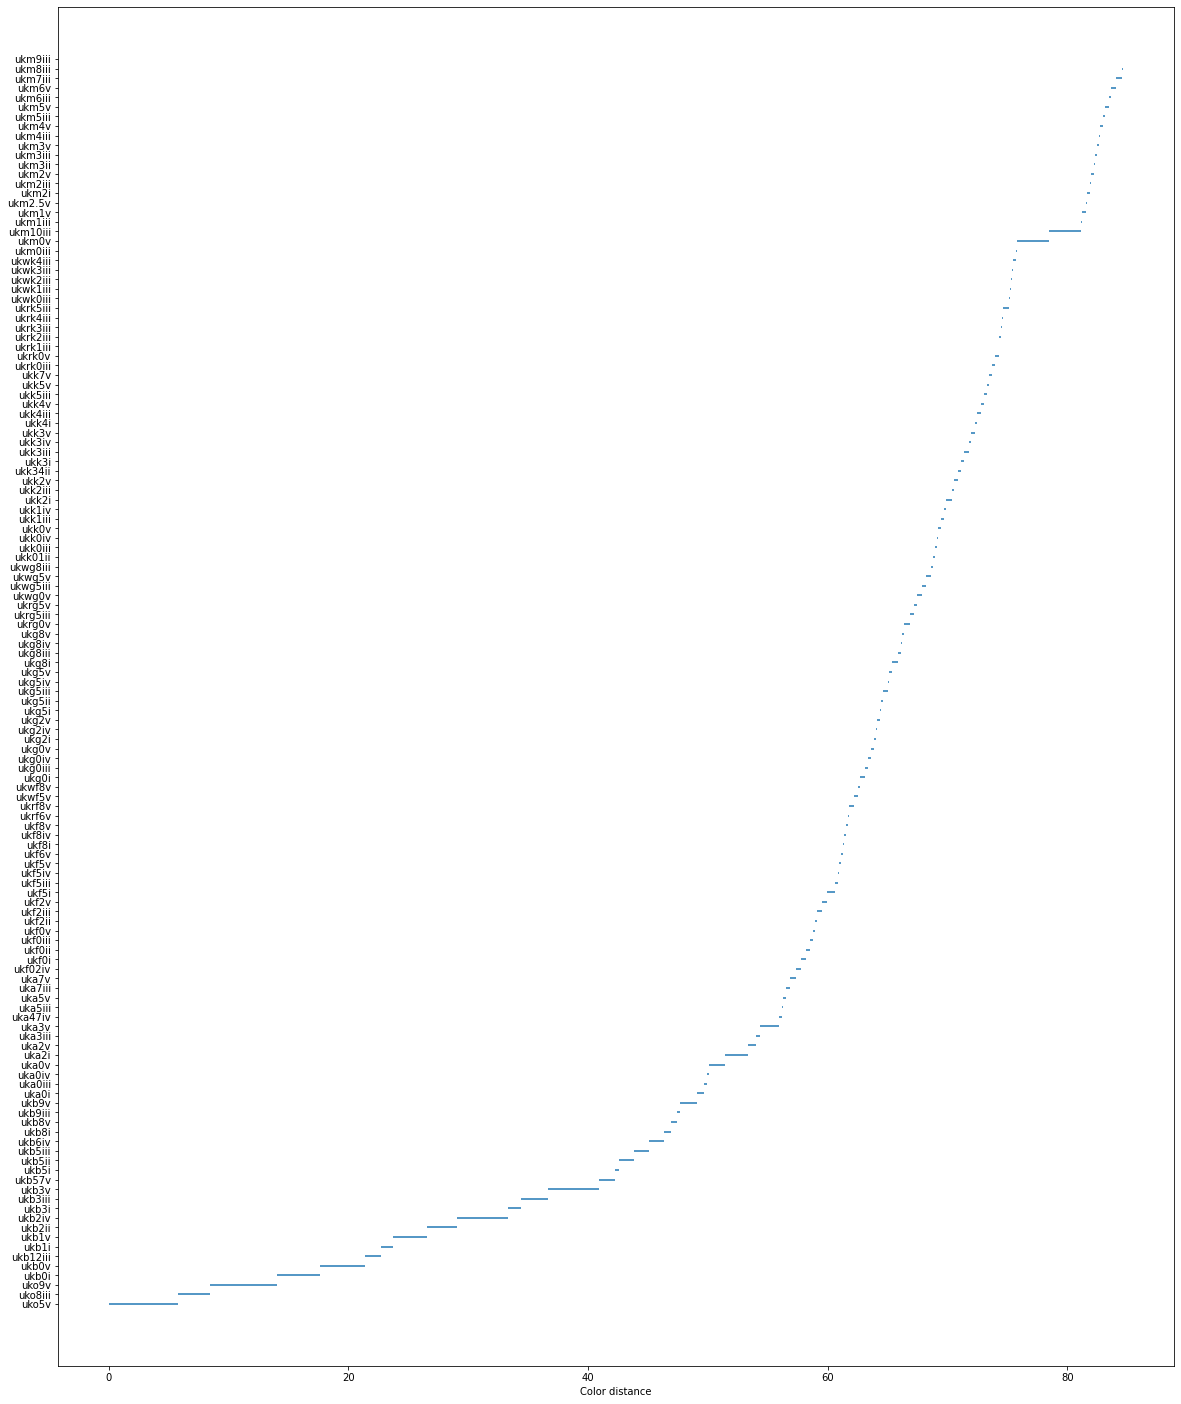

In [17]:
r = np.arange(len(sed_names))
plt.figure(figsize=(20, 25))
plt.hlines(r[:-1], xmin=starts, xmax=ends)
plt.yticks(r, sed_names)
plt.xlabel('Color distance')
plt.show()

In [18]:
seds.shape

(4771, 132)

In [19]:
def interpolate_sed(sed1, sed2, ninterp):
    seds = np.zeros((sed1.shape[0], ninterp))
    for idx in range(ninterp):
        frac_1 = (ninterp - idx)/(ninterp+1.0)
        frac_2 = (idx + 1)/ (ninterp+1.0)
        seds[:, idx] = frac_1*sed1 + frac_2*sed2
    return seds

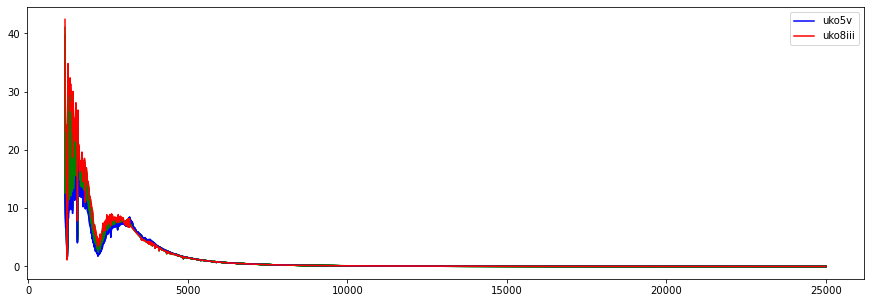

In [20]:
i = np.argmax(distances)
j = i + 1

ninterp = int(pdistances[i,j] / medd)
interp_seds = interpolate_sed(seds[:, i+1], seds[:, j+1], ninterp)

plt.figure()
plt.plot(seds[:,0], interp_seds, c='green')
plt.plot(seds[:,0], seds[:, 1+i], label=sed_names[i], c='blue')
plt.plot(seds[:,0], seds[:, 1+j], label=sed_names[j], c='red')
plt.legend()
plt.show()

In [21]:
all_photo = []
too_big = np.where(distances > medd)[0]
for i in tqdm(too_big):
    j = i + 1
    ninterp = int(pdistances[i,j] / medd)
    interp_seds = interpolate_sed(seds[:, i+1], seds[:, j+1], ninterp)
    interp_photo = np.zeros(interp_seds.shape[1], dtype=photo.dtype)
    for ised in range(interp_seds.shape[1]):
        interp_photo[ised] = calculator.compute(np.stack([seds[:, 0], interp_seds[:, ised]], axis=1))[0]
    all_photo.append(interp_photo)
all_photo = np.concatenate(all_photo)

  0%|          | 0/65 [00:00<?, ?it/s]

In [22]:
interp_colors = np.zeros((len(all_photo), len(color_names)))
for i, (a, b) in enumerate(color_names):
    interp_colors[:, i] = all_photo[a] / all_photo[b]

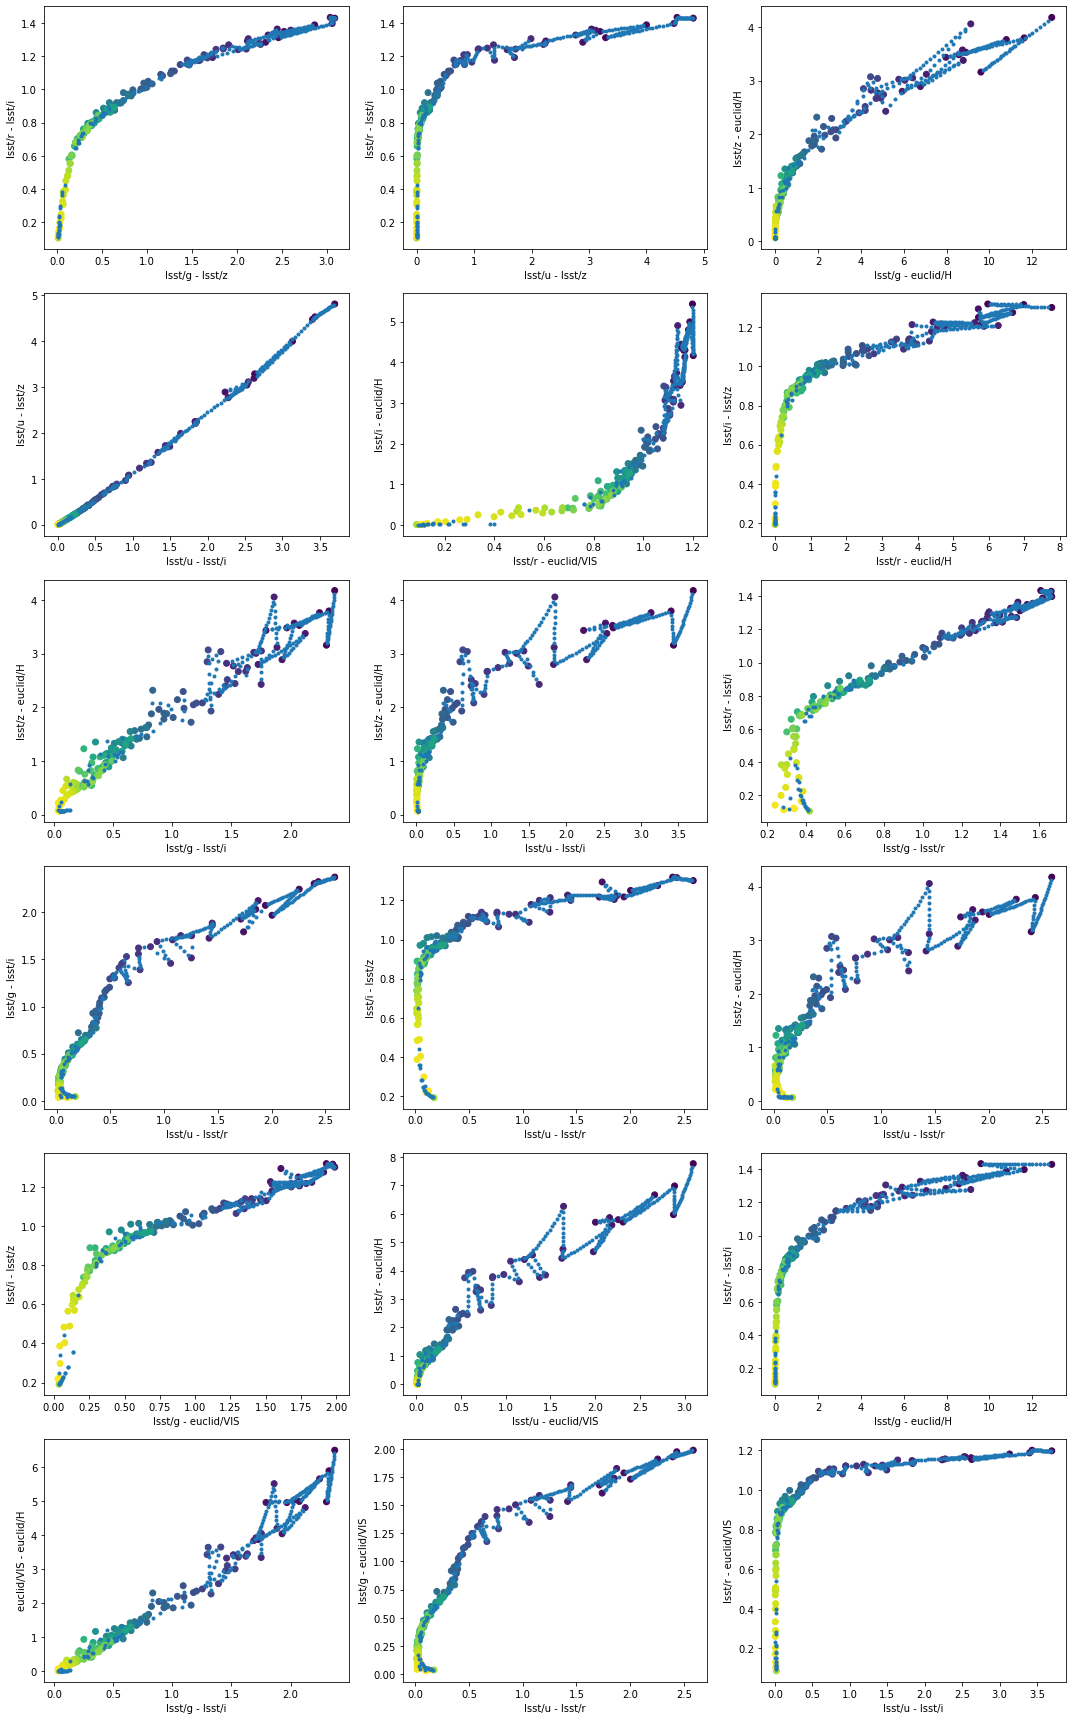

In [23]:
nrows = 6
fig, axes = plt.subplots(ncols=3, nrows=nrows, figsize=(15, 4 * nrows))

for ax, (a, b) in zip(axes.ravel(), pw):
    ax.scatter(colors[:, a], colors[:, b], c=np.arange(seds.shape[1]-1), marker='o')
    ax.scatter(interp_colors[:, a], interp_colors[:, b], marker='.')
    ax.set_xlabel(' - '.join(color_names[a]))
    ax.set_ylabel(' - '.join(color_names[b]))
plt.tight_layout()
plt.savefig('/home/aalvarez/Downloads/naive_sed_interp.pdf')
plt.show()